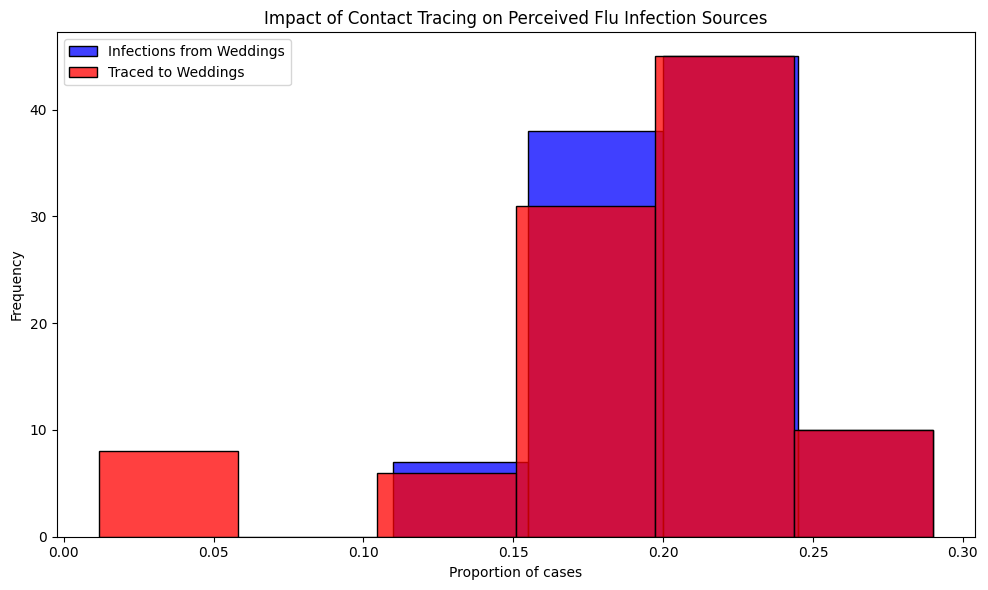

In [4]:
import numpy as np
np.random.seed(42)
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.

  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.

  Parameters:
  - m: Dummy parameter for iteration purposes.

  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(100)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

Question 1: Sampling Stages in the Model

The simulation involves multiple stages of sampling, each of which contributes to variability and potential bias in the results.

First, a random sample of individuals is selected to become infected. From a total population of 1,000 event attendees (200 wedding attendees and 800 brunch attendees), 10% are randomly chosen using np.random.choice() without replacement. This represents the infection process and assumes equal probability of infection across all individuals.

Second, primary contact tracing is applied to infected individuals. For each infected person, tracing success is determined using a Bernoulli trial implemented through np.random.rand() with a success probability of 0.20. This stage samples from the infected population and introduces additional randomness.

Third, secondary contact tracing is applied at the event level. If the number of successfully traced infected individuals at an event reaches or exceeds a predefined threshold, all infected individuals from that event are marked as traced. This step is conditional on earlier sampling and is non-random, leading to systematic overrepresentation of certain events.

Together, these sampling stages demonstrate how non-random tracing mechanisms can bias observed outcomes, even when the initial infection process is random.

Question 2

When the simulation is run with only 10 repetitions, the resulting distributions are highly variable and differ substantially between runs. The small number of simulations leads to unstable estimates and noisy histograms, making the results poorly reproducible.

Increasing the number of repetitions to 100 reduces variability and produces smoother distributions; however, noticeable differences between runs remain. This demonstrates that while larger sample sizes improve stability, randomness still influences the results when no reproducibility controls are applied.

With 1,000 repetitions, the distributions become more stable, but repeated executions of the script still produce slightly different outputs due to the use of random sampling without a fixed seed.

Question 3

To ensure reproducibility, a fixed random seed was set using np.random.seed(42) at the beginning of the script. This change ensures that the sequence of random numbers generated during the simulation remains identical across runs.

By fixing the random seed, the same individuals are selected for infection, the same tracing outcomes occur, and the resulting histograms are identical every time the script is executed. This modification does not remove randomness from the model but ensures that the randomness is controlled and reproducible, which is essential for scientific transparency and verification.